In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations as cb

# 1 随机采样阵生成

In [9]:
# 随机采样阵生成
def randSamplingMatrix(m,N):
    """
    Return m*N sampling matrix.
    Use type `np.float32`.
    """
    
    #用高斯分布抽样并单位化.
    A = np.random.randn(m,N).astype(np.float32) # Suggest float32+ in accordance with np.linalg.
    A = A/np.sqrt(m)
    return A

# 2 Restricted Isometry Constant 估计

In [22]:
# RIP测试.
class RIPtest:
    def __init__(self,A,s):
        """
        Return possible delta_s given matrix `A` and sparsity `s`.

        Contain 2 methods:
            `RIPtest(A,s).monteCarlo(nVec,show)`: Monte Carlo method;
            `RIPtest(A,s).singularValue()`: singularValue method.
        """
        self.A = A
        self.s = s
    #         
    # 
    # 
    #                 
    # Monte-Carlo method.
    def monteCarlo(self, nVec=1e5, show=True): # 这是一个对象方法.
        # def fun() 是类方法; def fun(self) 是对象方法.
        """
        Return possible delta_s given matrix `A` and sparsity `s`. 
        `nVec`: Number of vectors to test. 
        `show`: Whether to draw the distribution of amplifications.

        Running time:
            O(nVec=10000,N=10000,m=400)~70sec;
            
            O(nVec=5000,N=5000,m=200)~10sec;

            O(nVec=100000,N=200,m=50)~3sec.
        """
        
        N = self.A.shape[1]
        nVec = int(nVec) # 转化形如`1e5`的输入.
        V =  np.zeros((N,nVec),order='F',dtype=np.float32) # 由多个s-稀疏的列向量组成. 
        Supps = np.array([np.random.choice(range(N),self.s,replace=False) for i in range(nVec)])
            # 随机抽取支集, 存为每一行.
        Entries = np.array([np.random.randn(self.s).astype(np.float32) for i in range(nVec)])
            # 随机赋予支集项的值, 存为每一行. 未正规化.
        for j in range(nVec):
            # supp = Supps[j]
            # entries = Entries[j]
            V[Supps[j],j] = Entries[j]/np.linalg.norm(Entries[j])
        V = np.dot(self.A,V)
            # 象.
        Amplifications = np.array(list(map(lambda v:np.linalg.norm(v), np.transpose(V))))
        ampMax = np.max(Amplifications); delta1 = ampMax-1
        ampMin = np.min(Amplifications); delta2 = 1-ampMin
        delta = max(delta1,delta2)

        if show==True:
        # 用Gaussian近似检测delta估计是否超出3-sigma,若是,则认为delta即使再估计也不会显著增加,基本准确.
            var = np.var(Amplifications)
            mean = np.mean(Amplifications)
            threeSigma = 3*np.sqrt(var)
            ThreeSigmaPoints = [mean - threeSigma, mean + threeSigma]
            Xnorm = np.linspace(ThreeSigmaPoints[0],ThreeSigmaPoints[1],100)
            Ynorm = stats.norm.pdf((Xnorm-mean)/np.sqrt(var))/np.sqrt(var)

            plt.hist(Amplifications,bins=100,density=True,label='Amplifications')
            plt.plot(Xnorm,Ynorm,'r:',label='Gaussian Reference')
            plt.axvline(ThreeSigmaPoints[0],linestyle='-.',color='g',label='-3 sigma')
            plt.axvline(ThreeSigmaPoints[1],linestyle='--',color='m',label='+3 sigma')
            plt.xlabel('Amp.')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
            print("3-sigma points: [1 - {:}, 1 + {:}]".format(1-ThreeSigmaPoints[0],ThreeSigmaPoints[1]-1))
            
            if delta==delta1:
                side = 'Right'
            else:
                side = 'Left'
            print("Side:",side)
        return delta
    #
    #
    #
    # SingularValue method.
    def singularValue(self, SAFECODE, showSingularValues=True, mode='memory-saving'):
        """
        有内存泄漏危险, 勿用!

        确认使用时输入参数`SAFECODE=CONFIRM`.

        Return delta_s.

        `showSingularValues`: Whether to show the two max&min singularValues of all submatrices.
        
        Running time:
            `mode='memory-saving'`: O(N=200,m=20,s=3)~30sec; O(N=2000,m=20,s=2)~39sec; O(N=2000,m=20,s=3)~ >5min.
            
            `mode='fast'`: O(N=200,m=20,s=3)~23sec; O(N=2000,m=20,s=2)~27sec; O(N=2000,m=20,s=3)~ >2min(MemoryError).
        
        建议:
            1, 采用分布式计算, 因为耗时关于s指数级增长;
            
            2, 改用Monte-Carlo方法, 其估计概率已足够大;
            
            3, `fast`模式对于稍大矩阵几乎不能用, 基本上会报错`MemoryError`.
        """

        if SAFECODE!='CCONFIRM':
            print('Not safe!')
            return
        
        N = self.A.shape[1]

        # 以时间换空间: 使用s个指针Pointers, 列举指针组合.
        if mode=='memory-saving':
            PtrCombinations = cb(range(N),self.s)
            maxSv, minSv = 1, 1
            for ptr in PtrCombinations:
                ptr = list(ptr)
                Svs = np.linalg.svd(self.A[:,ptr])[1] 
                    # `Svs` for 'Singular Values'.
                    # Only accept float32+ type.
                maxSv = max(np.max(Svs),maxSv)
                minSv = min(np.min(Svs),minSv)

        # ↑↓ 以空间换时间.
        elif mode=='fast':
            Submatrices = np.array(list(cb(self.A.transpose(),self.s)))

            # Svs = np.array(list(map(np.linalg.svd,
            #           Submatrices))).reshape(1,-1)[0]
            # ↑↓ Equivalent.
            Svs = np.linalg.svd(Submatrices)[1].reshape(1,-1)[0]

            maxSv = max(Svs)
            minSv = min(Svs)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues==True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta
    #
    #
    #
    #
    # A mixed version.
    def mixedMethod(self, times=10000, showSingularValues=True):
        """
        A better and safe mixed version of Monte-Carlo & SingularValue.
        """
        N = self.A.shape[1]
        maxSv, minSv = 1, 1
        for t in range(times):
            comb = np.random.choice(range(N),self.s,replace=False)
            Svs = np.linalg.svd(self.A[:,comb])[1] 
                # `Svs` for 'Singular Values'.
                # Only accept float32+ type.
            maxSv = max(np.max(Svs),maxSv)
            minSv = min(np.min(Svs),minSv)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues==True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta

# 3 硬阈值函数

In [11]:
# 硬阈值函数
def hardThreshold(x,s,T0=[]):
    """
    Return x with its largest s-k entries and k entries indexed in T0, the rest set to 0.
    """
    N = len(x)
    k = len(T0)
    comparingVec = x.copy()
    comparingVec[T0]=0 #去掉支集项以寻找剩余元素的s-k个最大值.
    delta = np.abs(comparingVec).argsort()[:-(s-k+1):-1] #返回s-k个绝对最大值的索引.
        #这样的返回值不是标准的int64-type, 后续应转换.
    supp = np.append(T0, delta).astype('int64')
    new = np.zeros(N)
    new[supp]=x[supp]

    return new

# 4 Iterative Hard Thresholding-PKS 函数

In [12]:
# IHT-PKS
def IHT_PKS(y,Phi,s,x0='zeroVector',T0=[],mu=1, # 学习率
        haltingRule=('relativeSampleErr',0.1),maxIteration=1000,xReal=None,suppReal=None,showPrecisionAndRecall=True):
    """
    Return a dict {
        estimate: estimate of the (nearly) s-sparse signal x where y=Phi*x,
        iterCount: iteration times,
        eps: halting l2-norm error bound (not squared) in terms of y,
        y: samples,
        errY: actual l2-norm error (not squared) in terms of y,
        relativeErrY: errY/|y|_2,
        confusion: confusion matrix
        }.
    Print a message if reaching maxIteration.

    `y`: Sample vector.
    `Phi`: Sensing matrix.
    `s`: Sparsity of signal x.
    `x0`: (Optional) Initial estimate for x of iteration. Can receive a vector.
    `T0`: (Optional) Prior support of x.
    `mu`: (Optional) Learning rate.
    `haltingRule`: (Optional) By default ('relativeSampleErr',0.1), which halts the iteration when `|y-Phi*x|/|y|<0.1`.
    If set to `None`, never halt until maxIteration. 
    `maxIteration`: (Optional) Halt when iterating these many times.
    `xReal`: (Optional) Real x.
    `suppReal`: (Optional) Real supp(x), or if x is compressible then by default the largest `s` atoms of x, unless otherwise stated.
    `showPrecisionAndRecall`: (Optional) Whether to print precision & recall.
    """

    # Initialize
    N = Phi.shape[1]
    PhiTrans = Phi.transpose()
    yNorm = np.linalg.norm(y)
    if x0=='zeroVector':
        x0 = np.zeros(N)
    if haltingRule is None:
        eps = 0
    else:
        haltingRule,eps = haltingRule[0],haltingRule[1]
        if haltingRule=='relativeSampleErr':
            eps = eps*yNorm #转换为停机的绝对误差限.
        else:
            print('暂未配置其他停机规则,无返回.')
            return

    # Iterate
    for t in range(0,maxIteration):
        proxy = x0 + mu*np.dot(PhiTrans,(y-np.dot(Phi,x0))) #矩阵相乘用np.dot().
        x1 = hardThreshold(proxy,s,T0)
        err = np.linalg.norm(y-np.dot(Phi,x1))
        iterCount = t+1

        if err<eps:
            break
        x0 = x1
    else: #达到最大迭代次数, 停机.
        print('Reach maxIteration!')

    if any(xReal):
        if suppReal is None:
            suppReal = np.argsort(xReal)[:-(s+1):-1] #兼容compressible signal.
        
        # Compute confusion matrix.
        nPositive = np.sum(x1!=0)
        nTruePositive = np.sum(x1[suppReal]!=0)
        nFalsePositive = nPositive - nTruePositive
        nNegative = N - nPositive
        nFalseNegative = np.sum(x1[suppReal]==0)
        nTrueNegative = nNegative - nFalseNegative

        confusion = pd.DataFrame(np.array([
            [nTruePositive,nTrueNegative],
            [nFalsePositive,nFalseNegative]
        ]), columns=['positive','negative'],index=['true','false'])
        if showPrecisionAndRecall == True:
            print('precision:',nTruePositive/(nTruePositive + nFalsePositive))
            print('recall:',nTruePositive/(nTruePositive + nFalseNegative))
    
    else:
        confusion = None
    return dict(
        estimate=x1,
        iterCount=iterCount,
        eps=eps,
        y=y,
        errY=err,
        relativeErrY=err/yNorm,
        confusion=confusion
    )


# 5 测试信号生成

In [13]:
# Rademacher(1,-1,Prob=0.5) on support.
def randSparseSignal(N=2000,s=50,size=10000,returnSupports=False,allowLowerSparsity=False):
    """
    Generate `size` number of signals of dimension `N` and sparsity `s`.
    Aranged by columns.

    If `returnSupports`=`True` then also return Supports of Signals aranged by columns,
    repetitions might be included.
    """
    size = int(size) # 转化形如`1e5`的输入.
    V =  np.zeros((N,size),order='F',dtype=np.float32)
    Supps = np.array([np.random.choice(range(N),s,replace=allowLowerSparsity) for _ in range(size)])
        # 随机抽取支集, 存为每一行.
    Entries = np.array(
        [np.random.binomial(1,0.5,s).astype(np.float32)*2-1 for _ in range(size)])
        # 随机赋予支集项的值, 存为每一行.
    for j in range(size):
        V[Supps[j],j] = Entries[j]
    if returnSupports==True:
        return dict(
            Signals = V,
            Supports = Supps.transpose()
        )
    else:
        return V
    

# 6 数值测试

In [31]:
# Generate A, X.
np.random.seed(42)
A = randSamplingMatrix(1500,2000)
XX = randSparseSignal(N=2000,s=50,size=10000,returnSupports=True)
X, Supps = XX['Signals'],XX['Supports']
del XX

In [32]:
# RIP test. s=50.
RIPtest(A,150).mixedMethod(1000)

Max singular value: 1.3470454
Min singular value: 0.6683867


0.3470454216003418

In [53]:
# Average err.
Y = np.dot(A,X)
priorSuppRatio = 0.2 # Editable.
Rerrs = np.zeros(1000)
for t in range(1000):
    y = Y[:,t]
    x = X[:,t]
    supp = np.array(list(set(Supps[:,t])))
    prior = np.random.choice(supp,int(len(supp)*priorSuppRatio))
    result = IHT_PKS(y,A,50,T0=prior,haltingRule=None,
            maxIteration=50,xReal=x,suppReal=supp,showPrecisionAndRecall=False)
                # Editable.
    Rerrs[t] = result['relativeErrY']

Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!
Reach maxIteration!


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  3.,  1.,  1.,  0.,  2.,  0.,  3.,
         3.,  1.,  6.,  3.,  4.,  5.,  4.,  7., 11., 11., 11.,  8., 12.,
        13.,  8., 14., 21., 23., 10., 21., 22., 16., 18., 24., 35., 28.,
        22., 24., 25., 14., 21., 23., 23., 30., 33., 22., 18., 29., 22.,
        28., 21., 18., 20., 13., 21., 12., 18., 13., 15., 13.,  9., 14.,
        11., 13., 13.,  8.,  4., 11.,  3.,  5.,  9.,  4.,  8.,  6.,  4.,
         3.,  1.,  3.,  2.,  0.,  4.,  1.,  1.,  2.,  0.,  2.,  1.,  0.,
         4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  4.]),
 array([1.25701278, 1.26358754, 1.27016229, 1.27673704, 1.28331179,
        1.28988654, 1.2964613 , 1.30303605, 1.3096108 , 1.31618555,
        1.32276031, 1.32933506, 1.33590981, 1.34248456, 1.34905932,
        1.35563407, 1.36220882, 1.36878357, 1.37535832, 1.38193308,
        1.38850783, 1.39508258, 1.40165733, 1.40823209, 1.41480684,
        1.42138159, 1.42795634, 1.43453109, 1.44110585, 1.4476806 ,
        1.45425535, 1.4608

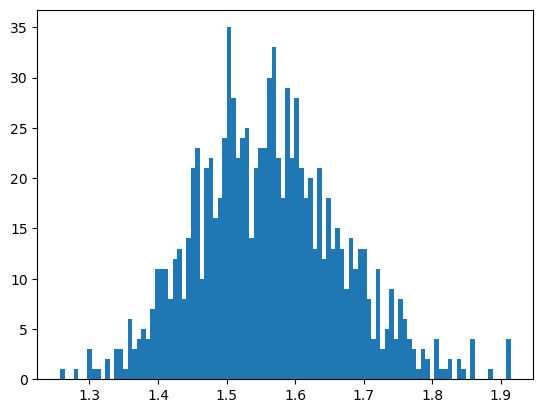

In [51]:
plt.hist(Rerrs,100)

# Debug region

In [8]:
np.random.seed(42)
A = randSamplingMatrix(200,2000)

In [41]:
x = np.array([1,1,2,2,1,0,8,6,5,3,7,0])
x = np.append(x,np.zeros(2000-12))

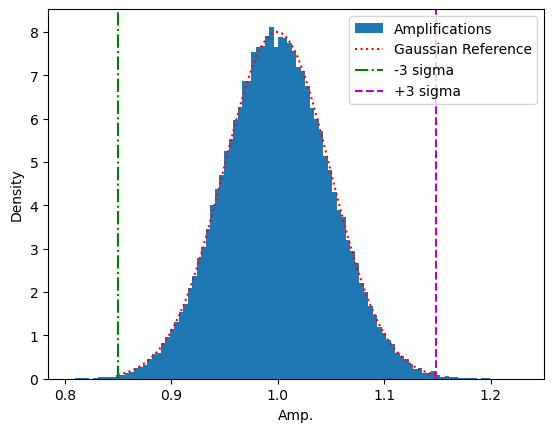

3-sigma points: [1 - 0.15027476102113724, 1 + 0.14875520020723343]
Side: Right


0.22908174991607666

In [9]:
RIPtest(A,50).monteCarlo()

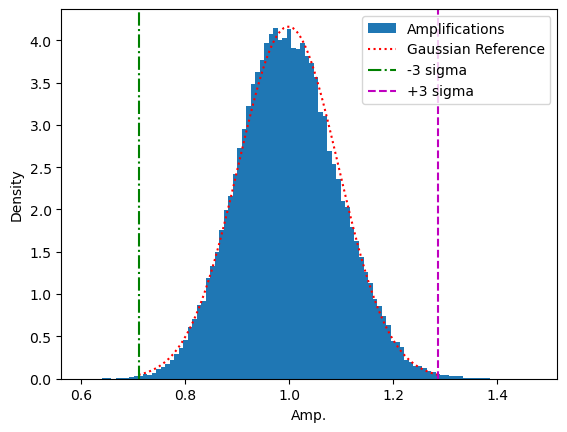

3-sigma points: [1 - 0.28908221423625946, 1 + 0.2860357016324997]
Side: Right


0.4718129634857178

In [79]:
np.random.seed(42)
RIPtest(A,3).monteCarlo(nVec=1e5)

In [37]:
# IHT:
result = IHT_PKS(np.dot(A,x),A,10,xReal=x,showPrecisionAndRecall=True)

precision: 1.0
recall: 1.0


In [27]:
Submatrices = np.array(list(cb(A.transpose(),3)))

In [42]:
Submatrices = np.array(list(cb(A.transpose(),3)))
Svs = np.array(list(map(lambda X: np.linalg.svd(X)[1],
            Submatrices))).reshape(1,-1)[0]


In [47]:
len(Svs.reshape(1,-1)[0])

3940200

In [17]:
a.reshape(1,-1)[0]

array([1. , 1.1, 1.2, 2. , 2.1, 2.2])

In [18]:
max([1,2])

2

In [12]:
a = np.array([1,2,3,4,5,6])

In [15]:
a[[2,2,3]]=np.array([0,1,0])

In [ ]:
list(cb(list(range(1000)),150))[1]

In [37]:
np.array(list(set([1,2,3,3])))

array([1, 2, 3])

In [21]:
np.random.choice(range(3),2,)

array([0, 0])

In [42]:
a is None

True